In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# Define your model and create a cost function
In this example, we want to fit a cubic polynomial of the form $y = ax^3 + bx^2 + cx + d$ to data. For later convenience, we'll create a simple method to evaluate the polynomial, although this isn't really necessary.

In [2]:
def evaluate_cubic(a,b,c,d,x):
    return a * x**3 + b * x**2 + c * x + d

Now let's define a new class for our cost function called `CubicCost`. Any cost function object must store the input and expected output data ($x$ and $y$ in this case), and implement a method called `evaluate` that computes the estimation error and its jacobian based on a set of model parameters.

In [3]:
class CubicCost:
    def __init__(self, x, y):
        # The residuals and jacobians need to be np.arrays
        # The easiest thing is to turn our scalar x,y into 1d arrays
        self.x = np.atleast_1d(x)
        self.y = np.atleast_1d(y)
        
    def evaluate(self, params, compute_jacobians=None):
        # Evaluate the model using the given parameters
        a, b, c, d = params
        y_predicted = evaluate_cubic(a, b, c, d, self.x)
        
        # The residual or error is the difference between the predicted and measured output variable
        residual = y_predicted - self.y
        
        # Compute the jacobian of the residual w.r.t. the model parameters if requested
        # The optimizer can request jacobians w.r.t. only a subset of parameters, if, 
        # for example, some parameters are held constant
        if compute_jacobians:
            jacobians = [None for _ in enumerate(params)]
            
            if compute_jacobians[0]:
                jacobians[0] = self.x**3 # d residual / d a
            if compute_jacobians[1]:
                jacobians[1] = self.x**2 # d residual / d b
            if compute_jacobians[2]:
                jacobians[2] = self.x    # d residual / d c
            if compute_jacobians[3]:
                jacobians[3] = 1.        # d residual / d d

            return residual, np.squeeze(jacobians)
        
        return residual

# Generate some test data

Note that `pyslam` deals with parameters as dictionaries, so we will create a `params_true` dictionary for later convenience.

In [4]:
params_true = {'a': 2., 'b': 4., 'c': -4., 'd': 0.}
x_data = np.linspace(-5, 5, 10)
y_data = evaluate_cubic(params_true['a'], params_true['b'], params_true['c'], params_true['d'], x_data)

# Set up the optimization problem

There are five steps to solving an optimization problem using `pyslam`:

1. Initialize the `Problem` object. The optimizer's behaviour can be customized by creating, modifying, and passing an `Options` object to the `Problem` constructor. Among other things, `Options` sets various thresholds and controls the optimizer's verbosity.
2. Create one or more cost function objects for your data. This will vary depending on how you define your cost function classes. To keep it simple, we'll create a `CubicCost` object for each $(x,y)$ pair.
3. Add each cost function object to the `Problem` and specify the names of the parameters it depends on. `pyslam` deals with parameters as dictionaries, so each parameter must have a unique identifier.
4. Give the `Problem` a dictionary of initial guesses for each parameter.
5. Call `Problem.solve`

In [5]:
from pyslam.problem import Problem, Options

options = Options()
options.print_summary = True

problem = Problem(options)

for x, y in zip(x_data, y_data):
    cost = CubicCost(x, y)
    problem.add_residual_block(cost, ['a','b','c','d'])
    
params_init = {'a': -2., 'b': 10., 'c': -6., 'd': -140.}
problem.initialize_params(params_init)

params_final = problem.solve()

Iterations:   1 | Cost: 3.735817e+05 --> 5.045051e-26


# Check the results

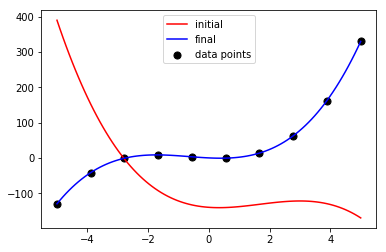

a error: [-0.]
b error: [-0.]
c error: [ 0.]
d error: [ 0.]


In [6]:
x_plot = np.linspace(-5,5,100)
y_est_init = evaluate_cubic(params_init['a'],params_init['b'],params_init['c'],params_init['d'],x_plot)
y_est_final = evaluate_cubic(params_final['a'],params_final['b'],params_final['c'],params_final['d'],x_plot)

plt.scatter(x_data, y_data, 50., 'k')
plt.plot(x_plot, y_est_init, 'r')
plt.plot(x_plot, y_est_final, 'b')
plt.legend(('initial', 'final', 'data points'))
plt.show()

for key in params_true.keys():
    print('{} error: {}'.format(key, params_true[key] - params_final[key]))

# Optional: Compute the covariance of the final parameter estimates

You can compute the covariance of the parameter estimates using `Problem.compute_covariance`. Once you've done that, you can obtain the covariance of any pair of parameters using the convenience method `Problem.get_covariance_block`. If need be, you can access the full covariance matrix `Problem._covariance_matrix`.

In [7]:
problem.compute_covariance()
print('variance of a: {}'.format( problem.get_covariance_block('a','a') ))
print('covariance of a and b: {}'.format( problem.get_covariance_block('a','b') ))
print('\nFull covariance matrix:\n{}'.format( problem._covariance_matrix ))

variance of a: 0.00017205419580419603
covariance of a and b: -2.2655492231125876e-20

Full covariance matrix:
[[ 0.00017205 -0.         -0.00311184 -0.        ]
 [-0.          0.00124261  0.         -0.01265625]
 [-0.00311184  0.          0.06610031  0.        ]
 [-0.         -0.01265625  0.          0.22890625]]
